In [2]:
import pandas as pd
import numpy as np
from eodhd import APIClient
import sys
sys.path.insert(0, "/Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src")
from Features import fundamental_features_new, fundamental_features, technical_features
import talib
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import sklearn
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import optuna
from optuna import Trial
import shap

In [3]:
zacks_fc = pd.read_csv("../data/fundamental_data/ZACKS_FC.csv", delimiter=',')
zacks_fc['per_end_date'] = pd.to_datetime(zacks_fc['per_end_date'])
zacks_fc['per_end_date'] = zacks_fc['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fc['filing_date'] = pd.to_datetime(zacks_fc['filing_date'])
zacks_fc['filing_date'] = zacks_fc['filing_date'].dt.tz_localize('US/Eastern')
zacks_fc = zacks_fc.sort_values('per_end_date').set_index('per_end_date')

zacks_fr = pd.read_csv("../data/fundamental_data/ZACKS_FR.csv", delimiter=',')
zacks_fr['per_end_date'] = pd.to_datetime(zacks_fr['per_end_date'])
zacks_fr['per_end_date'] = zacks_fr['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fr = zacks_fr.sort_values('per_end_date').set_index('per_end_date')

data = {
    "zacks_fc": zacks_fc,
    "zacks_fr": zacks_fr
}

C:\Users\manis\AppData\Local\Temp\ipykernel_26268\3539703636.py:1: DtypeWarning: Columns (4,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  zacks_fc = pd.read_csv("../data/fundamental_data/ZACKS_FC.csv", delimiter=',')
C:\Users\manis\AppData\Local\Temp\ipykernel_26268\3539703636.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  zacks_fr = pd.read_csv("../data/fundamental_data/ZACKS_FR.csv", delimiter=',')


In [4]:
tickers_df = pd.read_excel(r"C:/Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/data/sp1500_cleaned.xlsx")
tickers = tickers_df['ticker'].tolist()
len(tickers)

1506

In [5]:
combined_features = []
for ticker in tickers[:100]:
    data = {
    "zacks_fc": zacks_fc,
    "zacks_fr": zacks_fr
    }
    try:
        print(f"Processing ticker: {ticker}")
        obj = fundamental_features_new.BuildFeatures(data, ticker)
        obj.process_financial_statements()
        obj.extend_monthly()
        
        tech = technical_features.BuildFeatures(ticker)
        tech.build_technical_features()
        tech.technical_features.index = tech.technical_features.index.tz_convert('US/Eastern')

        df = pd.merge_asof(obj.fundamental_features, tech.technical_features, 
                           left_index=True, right_index=True, direction='nearest')

        obj.stock.sort_index(inplace=True)
        df = pd.merge_asof(df, obj.stock[['Close']],left_index=True, right_index=True, direction='backward')

        df.rename(columns={'Close': 'Close_Price'}, inplace=True)

        df['ticker'] = ticker  
        
        combined_features.append(df)
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

Processing ticker: VRSK


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.fundamental_features.loc[:, "eps"].fillna(self.data['zacks_fc'].loc[:, "basic_net_eps"], inplace=True)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future 

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing VRSK: Merge keys contain null values on left side
Processing ticker: EVTC


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing EVTC: Merge keys contain null values on left side
Processing ticker: AA


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing AA: Merge keys contain null values on left side
Processing ticker: PFG


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: NXPI


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing NXPI: Merge keys contain null values on left side
Processing ticker: CELH


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing CELH: Merge keys contain null values on left side
Processing ticker: AXP


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: VZ


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: BA


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing BA: Merge keys contain null values on left side
Processing ticker: RCL


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing RCL: Merge keys contain null values on left side
Processing ticker: DOW


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing DOW: Merge keys contain null values on left side
Processing ticker: CAT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: SCVL


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: JPM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing JPM: Merge keys contain null values on left side
Processing ticker: CVX


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: LII


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing LII: Merge keys contain null values on left side
Processing ticker: EME


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: KO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: DIS


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: PSX


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing PSX: Merge keys contain null values on left side
Processing ticker: XOM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: ALG


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: GE


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: HPQ


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: HD


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: IBM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: DXCM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: JNJ


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: MCD


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: MRK


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: MMM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: BAC


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing BAC: Merge keys contain null values on left side
Processing ticker: PFE


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: PG


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: BKU


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing BKU: Merge keys contain null values on left side
Processing ticker: T


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: TRV


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: TKR


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: SBRA


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing SBRA: Merge keys contain null values on left side
Processing ticker: RTX


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing RTX: Merge keys contain null values on left side
Processing ticker: WMT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CSCO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: PODD


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing PODD: Merge keys contain null values on left side
Processing ticker: INTC


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: MSFT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CYTK


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: KD


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing KD: Merge keys contain null values on left side
Processing ticker: AIN


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.fundamental_features.loc[:, "eps"].fillna(self.data['zacks_fc'].loc[:, "basic_net_eps"], inplace=True)
c:\Users\manis\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `i

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: C


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing C: Merge keys contain null values on left side
Processing ticker: AIG


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: PEB


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing PEB: Merge keys contain null values on left side
Processing ticker: EYE


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing EYE: Merge keys contain null values on left side
Processing ticker: ATO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: PI


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing PI: Merge keys contain null values on left side
Processing ticker: MO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: GNRC


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing GNRC: Merge keys contain null values on left side
Processing ticker: BOH


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: STEP


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing STEP: Merge keys contain null values on left side
Processing ticker: SAIA


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: BKH


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: IIIN


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing IIIN: Merge keys contain null values on left side
Processing ticker: STX


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: LEA


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: WLK


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: VLTO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing VLTO: Merge keys contain null values on left side
Processing ticker: MTRN


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.fundamental_features.loc[:, "eps"].fillna(self.data['zacks_fc'].loc[:, "basic_net_eps"], inplace=True)
c:\Users\manis\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `i

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: IP


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: KLG


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing KLG: Merge keys contain null values on left side
Processing ticker: TRNO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.fundamental_features.loc[:, "eps"].fillna(self.data['zacks_fc'].loc[:, "basic_net_eps"], inplace=True)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future 

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing TRNO: Merge keys contain null values on left side
Processing ticker: CBT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CALX


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing CALX: Merge keys contain null values on left side
Processing ticker: CSL


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: ABT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CNH


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error processing CNH: 'Index' object has no attribute 'tz_convert'
Processing ticker: AFL


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.fundamental_features.loc[:, "eps"].fillna(self.data['zacks_fc'].loc[:, "basic_net_eps"], inplace=True)
c:\Users\manis\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `i

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: APD


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: VC


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CHTR


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: AM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing AM: Merge keys contain null values on left side
Processing ticker: CHE


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: LBRT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing LBRT: Merge keys contain null values on left side
Processing ticker: CCK


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: HES


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing HES: Merge keys contain null values on left side
Processing ticker: CMC


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CTS


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: INSW


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing INSW: Merge keys contain null values on left side
Processing ticker: CW


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["Low"], self.stock["Close"])
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:503: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Williams_R"] = talib.WILLR(self.stock["H

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: APOG


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: BHF


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing BHF: Merge keys contain null values on left side
Processing ticker: DCI


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: CRSR


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing CRSR: Merge keys contain null values on left side
Processing ticker: ADM


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing ADM: Merge keys contain null values on left side
Processing ticker: DY


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing DY: Merge keys contain null values on left side
Processing ticker: ESE


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: ADP


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing ADP: Merge keys contain null values on left side
Processing ticker: LMAT


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing LMAT: Merge keys contain null values on left side
Processing ticker: AZO


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: FSS


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: AVY


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Processing ticker: FCF


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI
Error processing FCF: Merge keys contain null values on left side


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

In [6]:
tech.technical_features

,SMA_50,SMA_200,Chaikin_ADI_Line,Chaikin_ADI_Oscillator,ADM_Index,ADM_Index_Rating,Absolute_Price_Oscillator,Average_True_Range,Average_Price,Bollinger_Band_Upper,...,Midpoint_Price_over_period,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Summation,Triple_Exponential_Moving_Average,Triple_Exponential_Moving_Average_Oscillator,True_Range,Close_Price
Date,,,,,,,,,,,,,,,,,,,,,
1992-06-10 00:00:00-04:00,NaN,NaN,27000.00000000,NaN,NaN,NaN,NaN,NaN,1.73860754,NaN,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,1.76807547
1992-06-11 00:00:00-04:00,NaN,NaN,23800.00000000,NaN,NaN,NaN,NaN,NaN,1.76580954,NaN,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,0.02720117,1.75900924
1992-06-12 00:00:00-04:00,NaN,NaN,30066.66666667,NaN,NaN,NaN,NaN,NaN,1.77034378,NaN,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,0.02720189,1.77714407
1992-06-15 00:00:00-04:00,NaN,NaN,30066.66666667,NaN,NaN,NaN,NaN,NaN,1.77714407,NaN,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,0.00000000,1.77714407
1992-06-16 00:00:00-04:00,NaN,NaN,7266.66666667,NaN,NaN,NaN,NaN,NaN,1.78167605,1.78346079,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,0.02720116,1.76807547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-12 00:00:00-04:00,16.33976889,16.20531170,54397726.78224619,-262337.98580310,11.57476686,10.57629922,-0.34036121,0.39300512,15.40249991,15.83972995,...,15.91499996,15.36999989,8245,16.44000053,8238,488.23246098,15.55744621,15.62883028,0.27000046,15.43000031
2025-03-13 00:00:00-04:00,16.31154915,16.21615311,54003652.63638156,-349104.87580676,11.44494529,10.39505134,-0.36612462,0.38779045,15.50999975,15.73180013,...,15.91499996,15.36999989,8245,16.44000053,8238,487.65509987,15.47379500,15.56070953,0.31999969,15.46000004
2025-03-14 00:00:00-04:00,16.29291424,16.22884561,54585787.08559722,-167639.01734811,10.87403325,10.06154670,-0.35942289,0.38794830,15.70000005,15.84840950,...,15.91499996,15.36999989,8245,16.44000053,8238,486.92183685,15.46593194,15.57214998,0.39000034,15.84000015


In [7]:
combined_features[0]

,total revenue,ebitda,eps,Dividend Payout Ratio,total_current_assets,,m_ticker,ticker,comp_name,comp_name_2,...,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Summation,Triple_Exponential_Moving_Average,Triple_Exponential_Moving_Average_Oscillator,True_Range,Close_Price,Close_Price
filing_date,,,,,,,,,,,,,,,,,,,,,
2006-04-30 20:00:00-04:00,2402.20000000,467.39980000,1.01000000,NaN,2281.80000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,27.54802132,1127,29.14418983,1135,846.23421478,28.93848024,28.81938488,0.46979303,28.70835495,29.04231262
2006-05-31 20:00:00-04:00,2402.20000000,467.39980000,1.01000000,NaN,2281.80000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,29.31964684,1150,30.93280029,1158,891.51554489,30.56084728,30.69514183,0.53771540,30.81959724,30.93279839
2006-06-30 20:00:00-04:00,2402.20000000,467.39980000,1.01000000,NaN,2281.80000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,29.61398125,1167,31.49881554,1180,910.41483307,30.68834328,30.71608456,0.53205721,31.49881554,31.49881744
2006-07-31 20:00:00-04:00,2459.80000000,386.50010000,0.76000000,NaN,1843.70000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,29.94792366,1201,30.73470116,1195,921.48606110,30.46168771,30.45318144,0.78111341,29.94792366,30.56489372
2006-08-31 20:00:00-04:00,2459.80000000,386.50010000,0.76000000,NaN,1843.70000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,29.95359039,1219,30.64979744,1213,907.59602356,30.06959355,29.99399417,0.15848390,30.05546951,30.13471794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 20:00:00-04:00,4053.30000000,627.09990000,2.22000000,NaN,28186.70000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,77.59693146,5687,82.19269562,5680,2378.31659698,78.50285733,79.36541895,1.05238747,79.20932007,79.20931244
2024-06-30 20:00:00-04:00,4310.80000000,443.89990000,1.49000000,NaN,28541.30000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,74.66108704,5699,78.72235107,5704,2335.20913696,77.43311184,76.43542012,1.44141212,75.97588348,76.40441132
2024-07-31 20:00:00-04:00,4310.80000000,443.89990000,1.49000000,NaN,28541.30000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,77.38807678,5731,85.17946625,5720,2393.82952118,79.54803137,80.95022209,2.56141998,77.38807678,79.38462067


In [8]:
final_df = pd.concat(combined_features)
final_df = final_df.sort_index()
print("Combined DataFrame shape:", final_df.shape)

# 5. Data preprocessing and handling missing values
print("Before processing missing values, final_df shape:", final_df.shape)
print("Missing values per column:")
print(final_df.isnull().sum())

# Use forward fill and backward fill to fill in missing values
final_df = final_df.ffill().bfill()
print("\nAfter forward fill and backward fill, final_df shape:", final_df.shape)
print("Missing values per column:")
print(final_df.isnull().sum())

# Drop columns that are entirely missing
final_df = final_df.dropna(axis=1, how='all')
print("\nAfter dropping columns with all missing values, final_df shape:", final_df.shape)
print("Missing values per column:")
print(final_df.isnull().sum())

Combined DataFrame shape: (13388, 171)
Before processing missing values, final_df shape: (13388, 171)
Missing values per column:
total revenue                                       0
ebitda                                            445
eps                                               127
Dividend Payout Ratio                           13388
total_current_assets                                0
                                                ...  
Triple_Exponential_Moving_Average                 145
Triple_Exponential_Moving_Average_Oscillator      154
True_Range                                        142
Close_Price                                         0
Close_Price                                       142
Length: 171, dtype: int64

After forward fill and backward fill, final_df shape: (13388, 171)
Missing values per column:
total revenue                                       0
ebitda                                              0
eps                                             

In [9]:
final_df.shape

(13388, 167)

In [10]:
final_df.head()

,total revenue,ebitda,eps,total_current_assets,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,...,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Summation,Triple_Exponential_Moving_Average,Triple_Exponential_Moving_Average_Oscillator,True_Range,Close_Price,Close_Price
filing_date,,,,,,,,,,,,,,,,,,,,,
2006-01-31 19:00:00-05:00,6628.00000000,1985.00000000,0.22000000,21611.00000000,CSCO,CSCO,Cisco Systems,"Cisco Systems, Inc.",NASDAQ,USD,...,12.03595638,4016,12.72524071,4010,362.47050095,12.34658913,12.51897362,0.17894899,12.31432056,12.30769444
2006-02-28 19:00:00-05:00,6628.00000000,1985.00000000,0.22000000,21611.00000000,CSCO,CSCO,Cisco Systems,"Cisco Systems, Inc.",NASDAQ,USD,...,12.95720863,4029,13.95799828,4042,381.08780575,13.32670790,13.47326990,0.58324339,13.95799828,13.41452408
2006-02-28 19:00:00-05:00,88327.00000000,7130.00000000,0.28670000,43825.00000000,WMS,WMT,Walmart,Walmart Inc.,NYSE,USD,...,10.13279438,8457,10.52329826,8448,308.00107861,10.22070629,10.19890703,0.10772396,10.13279438,10.17992210
2006-02-28 19:00:00-05:00,14997.00000000,2177.00000000,0.60000000,15269.00000000,HOMD,HD,Home Depot,"The Home Depot, Inc.",NYSE,USD,...,24.11391640,6155,26.29989624,6168,753.62595558,26.09140556,25.82466830,0.73484011,26.29989624,26.02819824
2006-02-28 19:00:00-05:00,1253.81500000,210.20700000,1.25000000,2034.99200000,AZO,AZO,AutoZone,"AutoZone, Inc.",NYSE,USD,...,96.68000031,3759,100.29000092,3760,2922.60001373,98.81171848,99.72316448,6.73000336,100.29000092,96.68000031


In [11]:
final_df.index = pd.to_datetime(final_df.index)
unique_dates = final_df.index.unique()
#target = pd.Timestamp('2006-04-30 19:00:00-05:00')
for date in unique_dates:
    filtered = final_df.loc[final_df.index == date]
    print(f"Date: {date}, Shape: {filtered.shape}")

Date: 2006-01-31 19:00:00-05:00, Shape: (1, 167)
Date: 2006-02-28 19:00:00-05:00, Shape: (6, 167)
Date: 2006-03-31 19:00:00-05:00, Shape: (20, 167)
Date: 2006-04-30 20:00:00-04:00, Shape: (60, 167)
Date: 2006-05-31 20:00:00-04:00, Shape: (60, 167)
Date: 2006-06-30 20:00:00-04:00, Shape: (60, 167)
Date: 2006-07-31 20:00:00-04:00, Shape: (60, 167)
Date: 2006-08-31 20:00:00-04:00, Shape: (60, 167)
Date: 2006-09-30 20:00:00-04:00, Shape: (60, 167)
Date: 2006-10-31 19:00:00-05:00, Shape: (60, 167)
Date: 2006-11-30 19:00:00-05:00, Shape: (60, 167)
Date: 2006-12-31 19:00:00-05:00, Shape: (60, 167)
Date: 2007-01-31 19:00:00-05:00, Shape: (60, 167)
Date: 2007-02-28 19:00:00-05:00, Shape: (60, 167)
Date: 2007-03-31 20:00:00-04:00, Shape: (60, 167)
Date: 2007-04-30 20:00:00-04:00, Shape: (61, 167)
Date: 2007-05-31 20:00:00-04:00, Shape: (60, 167)
Date: 2007-06-30 20:00:00-04:00, Shape: (60, 167)
Date: 2007-07-31 20:00:00-04:00, Shape: (60, 167)
Date: 2007-08-31 20:00:00-04:00, Shape: (60, 167)
Da

In [47]:
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

# final_df['next_return'] = final_df['Close_Price'].shift(-1) / final_df['Close_Price'] - 1
final_df = (
    final_df
    .groupby('ticker', group_keys=False)
    .apply(lambda df_t: df_t.assign(
        next_return = df_t['Close_Price'].shift(-1) / df_t['Close_Price'] - 1
    ))
)
# final_df['next_return_median'] = final_df['Median_Price'].shift(-1) / final_df['Median_Price'] - 1
print(final_df.shape)

(13388, 168)


C:\Users\manis\AppData\Local\Temp\ipykernel_26268\4142810418.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df_t: df_t.assign(


In [48]:
train_df = final_df['2006-01-31':'2019-01-01'].copy()
valid_df = final_df['2019-01-01': '2022-01-01'].copy()
test_df = final_df['2022-01-01':].copy()

In [49]:
train_df.shape

(9208, 168)

In [50]:
x_train = train_df.drop(['next_return', 'next_return_median'], axis=1)
y_train = train_df['next_return']
y_train_median = train_df['next_return_median']

x_valid = valid_df.drop(['next_return', 'next_return_median'], axis=1)
y_valid = valid_df['next_return']
y_valid_median = valid_df['next_return_median']

x_test = test_df.drop(['next_return', 'next_return_median'], axis=1)
y_test = test_df['next_return']
y_test_median = test_df['next_return_median']

In [51]:
# 1. Identify numeric and non-numeric columns in x_train
numeric_cols = x_train.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
non_numeric_cols = x_train.select_dtypes(exclude=['int64', 'float64', 'int32', 'float32']).columns

# 2. Initialize the scaler and scale the numeric columns
scaler = StandardScaler()
x_train_numeric_scaled = scaler.fit_transform(x_train[numeric_cols])
x_valid_numeric_scaled = scaler.transform(x_valid[numeric_cols])
x_test_numeric_scaled = scaler.transform(x_test[numeric_cols])

# 3. Convert the scaled numeric arrays back to DataFrames
x_train_numeric_scaled_df = pd.DataFrame(x_train_numeric_scaled, columns=numeric_cols, index=x_train.index)
x_valid_numeric_scaled_df = pd.DataFrame(x_valid_numeric_scaled, columns=numeric_cols, index=x_valid.index)
x_test_numeric_scaled_df = pd.DataFrame(x_test_numeric_scaled, columns=numeric_cols, index=x_test.index)

# Now x_train_final, x_valid_final, and x_test_final have the numeric features scaled and the string features intact.
rf = RandomForestRegressor(random_state=1)
rf.fit(x_train_numeric_scaled_df, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred = rf.predict(x_valid_numeric_scaled_df)
mse_valid = mean_squared_error(y_valid, y_valid_pred)
print("Validation MSE:", mse_valid)

Validation MSE: 0.010649619535944338


In [52]:
# Using the model's built-in score method
r2_builtin = rf.score(x_valid_numeric_scaled_df, y_valid)
print("R^2 score (built-in):", r2_builtin)

# Alternatively, predict and then compute R² with r2_score:
y_valid_pred = rf.predict(x_valid_numeric_scaled_df)
r2 = r2_score(y_valid, y_valid_pred)
print("R^2 score:", r2)

R^2 score (built-in): -0.16683191117053942
R^2 score: -0.16683191117053942


In [53]:
def objective(trial: Trial, train=None, labels=None, val=None, val_labels=None):
    # Suggest hyperparameters
    rf_n_estimators = trial.suggest_int('n_estimators', 10, 100, step=5)
    rf_max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    rf_max_depth = trial.suggest_int('max_depth', 2, 10)
    
    rf_reg = RandomForestRegressor(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        min_samples_leaf=rf_min_samples_leaf,
        max_features=rf_max_features,
        random_state=1
    )
    
    rf_reg.fit(train, labels)
    preds = rf_reg.predict(val)
    
    # Compute R-squared score
    r2 = r2_score(val_labels, preds)
    return r2

In [54]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, train=x_train_numeric_scaled_df, labels=y_train, val=x_valid_numeric_scaled_df, val_labels=y_valid), n_trials=400)

[I 2025-03-18 21:29:34,701] A new study created in memory with name: no-name-1ac6d37b-5a91-4912-850a-4616a8ebd353
[I 2025-03-18 21:29:35,933] Trial 0 finished with value: -0.03297647625898059 and parameters: {'n_estimators': 35, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'max_depth': 8}. Best is trial 0 with value: -0.03297647625898059.
[I 2025-03-18 21:29:36,501] Trial 1 finished with value: -0.00931759900397977 and parameters: {'n_estimators': 50, 'max_features': 'log2', 'min_samples_leaf': 4, 'max_depth': 4}. Best is trial 1 with value: -0.00931759900397977.
[I 2025-03-18 21:29:38,855] Trial 2 finished with value: -0.01799971573425685 and parameters: {'n_estimators': 85, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'max_depth': 6}. Best is trial 1 with value: -0.00931759900397977.
[I 2025-03-18 21:29:39,489] Trial 3 finished with value: -0.005786454719823864 and parameters: {'n_estimators': 100, 'max_features': 'log2', 'min_samples_leaf': 9, 'max_depth': 2}. Best is trial 3 wi

In [55]:
study.best_params

{'n_estimators': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 9,
 'max_depth': 5}

In [56]:
rf = RandomForestRegressor(**study.best_params)

In [57]:
rf.fit(x_train_numeric_scaled_df, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred_op = rf.predict(x_valid_numeric_scaled_df)
mse_valid_op = mean_squared_error(y_valid, y_valid_pred_op)
print("Validation MSE:", mse_valid_op)

Validation MSE: 0.009361775617397977


In [58]:
# predict and then compute R2 with r2_score:
y_valid_pred_op = rf.predict(x_valid_numeric_scaled_df)
r2 = r2_score(y_valid, y_valid_pred_op)
print("R^2 score:", r2)

ss_res = np.sum((y_valid - y_valid_pred_op) ** 2)
ss_tot = np.sum((y_valid - np.mean(y_valid)) ** 2)
#r2_manual = 1 - (ss_res / ss_tot)

#print("Manual R² score:", r2_manual)
print("SS total:", ss_tot)
print("SS residual:", ss_res)

R^2 score: -0.025728524735471048
SS total: 19.714217598457264
SS residual: 20.22143533357963


                                           Feature  Importance
145                    Percentage_Price_Oscillator  0.08671321
16                                     ebit_margin  0.04990358
141                  Normalized_Average_True_Range  0.04701306
130  one_day_rate_of_change_of_a_triple_smooth_ema  0.04238786
120                                    MACD_Signal  0.03666468
..                                             ...         ...
69                                   Ladder_Bottom  0.00000000
68                               Kicking_by_Length  0.00000000
67                                         Kicking  0.00000000
66                                 Inverted_Hammer  0.00000000
158                                    Close_Price  0.00000000

[159 rows x 2 columns]


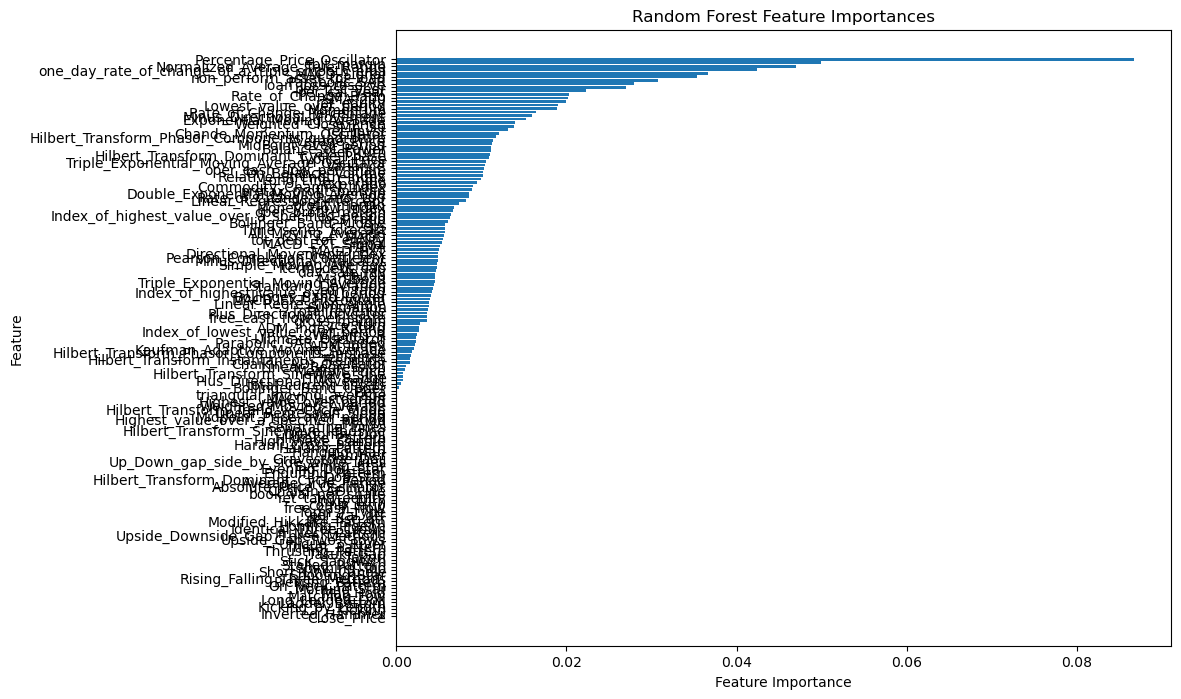

In [59]:
# Get feature importances from the model
importances = rf.feature_importances_

# Create a DataFrame for easier viewing and sorting
feature_importance_df = pd.DataFrame({
    'Feature': x_train_numeric_scaled_df.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features on top
plt.show()

In [60]:
features = feature_importance_df[feature_importance_df['Importance'] > 0.005]
features.shape

(55, 2)

In [61]:
features.head(15)

,Feature,Importance
145,Percentage_Price_Oscillator,0.08671321
16,ebit_margin,0.04990358
141,Normalized_Average_True_Range,0.04701306
130,one_day_rate_of_change_of_a_triple_smooth_ema,0.04238786
120,MACD_Signal,0.03666468
10,non_perform_asset_tot_loan,0.03533990
113,Parabolic_SAR,0.03078950
11,loan_loss_reserve,0.02793794
4,per_fisc_year,0.02695348
6,per_cal_year,0.02231893


In [62]:
x_train_red = x_train_numeric_scaled_df[features['Feature']]
x_valid_red = x_valid_numeric_scaled_df[features['Feature']]
x_test_red = x_test_numeric_scaled_df[features['Feature']]
x_train_red.shape

(9208, 55)

In [63]:
rf = RandomForestRegressor(random_state=1)
rf.fit(x_train_red, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred_red = rf.predict(x_valid_red)
mse_valid_red = mean_squared_error(y_valid, y_valid_pred_red)
print("Validation MSE:", mse_valid_red)

Validation MSE: 0.009984524907914606


In [64]:
# predict and then compute R2 with r2_score:
y_valid_pred_red = rf.predict(x_valid_red)
r2 = r2_score(y_valid, y_valid_pred_red)
print("R^2 score:", r2)

ss_res = np.sum((y_valid - y_valid_pred_red) ** 2)
ss_tot = np.sum((y_valid - np.mean(y_valid)) ** 2)
#r2_manual = 1 - (ss_res / ss_tot)

#print("Manual R² score:", r2_manual)
print("SS total:", ss_tot)
print("SS residual:", ss_res)

R^2 score: -0.0939604218826946
SS total: 19.714217598457264
SS residual: 21.56657380109555


In [85]:
# Combine validation + test sets (using your "x_valid_red, x_test_red" & "y_valid, y_test")
x_out_of_sample = pd.concat([x_valid_red, x_test_red], axis=0)
y_out_of_sample = pd.concat([y_valid, y_test], axis=0)

print("Out-of-sample feature set shape:", x_out_of_sample.shape)
print("Out-of-sample return series shape:", y_out_of_sample.shape)

Out-of-sample feature set shape: (4180, 55)
Out-of-sample return series shape: (4180,)


In [102]:
x_out_of_sample.shape

(4180, 55)

In [86]:
# Predict out-of-sample
y_out_of_sample_pred = rf.predict(x_out_of_sample)

# Make a DataFrame with actual and predicted returns
strategy_df = pd.DataFrame({
    "actual_return": y_out_of_sample,
    "predicted_return": y_out_of_sample_pred
}, index=y_out_of_sample.index)

# Determine long or short
strategy_df['position'] = np.where(strategy_df['predicted_return'] > 0, 1, -1)

# Per-row strategy return (row ~ single ticker at a given date)
strategy_df['strategy_return'] = strategy_df['position'] * strategy_df['actual_return']

In [111]:
strategy_df.index.min(), strategy_df.index.max()

(Timestamp('2019-01-31 19:00:00-0500', tz='US/Eastern'),
 Timestamp('2024-12-31 19:00:00-0500', tz='US/Eastern'))

In [108]:
len(strategy_df.index.unique())

72

In [87]:
daily_strategy = strategy_df.groupby(strategy_df.index).agg({
    'strategy_return': 'mean',
    'actual_return': 'mean'  # for a "buy-and-hold-all" baseline
})

daily_strategy.rename(columns={
    'strategy_return': 'mean_strategy_return',
    'actual_return': 'mean_actual_return'
}, inplace=True)

daily_strategy.head()

,mean_strategy_return,mean_actual_return
filing_date,,
2019-01-31 19:00:00-05:00,-0.03346413,0.05276183
2019-02-28 19:00:00-05:00,-0.00475969,0.00899245
2019-03-31 20:00:00-04:00,-0.00403475,0.01849820
2019-04-30 20:00:00-04:00,-0.02277707,-0.05427850
2019-05-31 20:00:00-04:00,0.07505946,0.10845725


In [112]:
daily_strategy.shape

(72, 6)

In [122]:
daily_strategy['cumulative_strategy'] = (1 + daily_strategy['mean_strategy_return']).cumprod()

In [123]:
daily_strategy['cumulative_buy_and_hold'] = (1 + daily_strategy['mean_actual_return']).cumprod()

In [124]:
initial_capital = 1_000_000.0

# Long-short portfolio value over time
daily_strategy['portfolio_value_strategy'] = (
    initial_capital * (1 + daily_strategy['mean_strategy_return']).cumprod()
)

# Buy-and-hold portfolio value over time
daily_strategy['portfolio_value_bh'] = (
    initial_capital * (1 + daily_strategy['mean_actual_return']).cumprod()
)

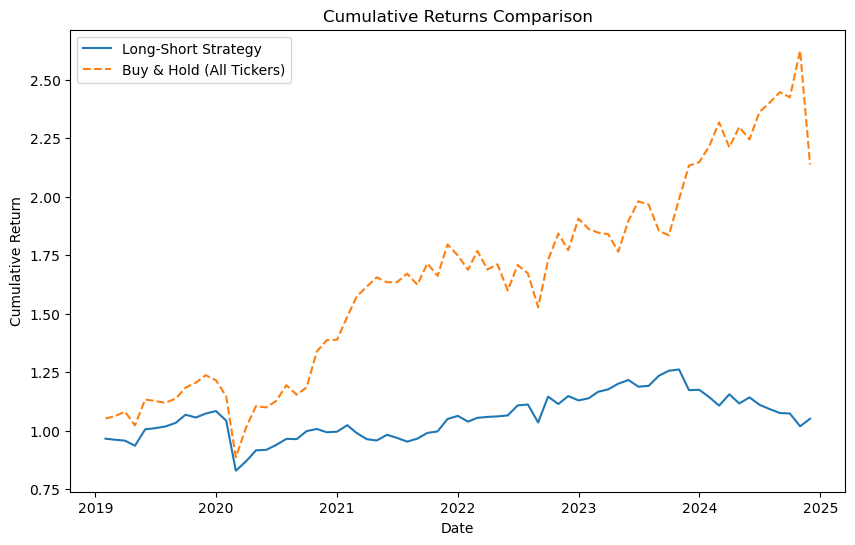

In [125]:
plt.figure(figsize=(10, 6))
plt.plot(daily_strategy.index, daily_strategy['cumulative_strategy'], label='Long-Short Strategy')
plt.plot(daily_strategy.index, daily_strategy['cumulative_buy_and_hold'], label='Buy & Hold (All Tickers)', linestyle='--')
plt.title("Cumulative Returns Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


In [92]:
final_strategy_value = daily_strategy['portfolio_value_strategy'].iloc[-2]
final_buy_hold_value = daily_strategy['portfolio_value_bh'].iloc[-2]

profit_strategy = final_strategy_value - initial_capital
profit_buy_hold = final_buy_hold_value - initial_capital

print(f"Final Strategy Value: ${final_strategy_value:,.2f}")
print(f"Final Strategy Profit: ${profit_strategy:,.2f}")

print(f"\nFinal Buy & Hold Value: ${final_buy_hold_value:,.2f}")
print(f"Final Buy & Hold Profit: ${profit_buy_hold:,.2f}")

Final Strategy Value: $1,051,550.11
Final Strategy Profit: $51,550.11

Final Buy & Hold Value: $2,138,160.72
Final Buy & Hold Profit: $1,138,160.72


In [93]:
monthly_mean_strategy = daily_strategy['mean_strategy_return'].mean()
monthly_std_strategy = daily_strategy['mean_strategy_return'].std()

monthly_mean_bh = daily_strategy['mean_actual_return'].mean()
monthly_std_bh = daily_strategy['mean_actual_return'].std()

strategy_annual_return = (1 + monthly_mean_strategy)**12 - 1
strategy_annual_vol    = monthly_std_strategy * np.sqrt(12)
strategy_sharpe        = (monthly_mean_strategy / monthly_std_strategy) * np.sqrt(12) if monthly_std_strategy != 0 else np.nan

bh_annual_return = (1 + monthly_mean_bh)**12 - 1
bh_annual_vol    = monthly_std_bh * np.sqrt(12)
bh_sharpe        = (monthly_mean_bh / monthly_std_bh) * np.sqrt(12) if monthly_std_bh != 0 else np.nan

print("Long-Short Strategy Performance")
print(f"Annual Return:     {strategy_annual_return:.2%}")
print(f"Annual Volatility: {strategy_annual_vol:.2%}")
print(f"Sharpe Ratio:      {strategy_sharpe:.3f}")

print("Buy & Hold (All Tickers) Performance")
print(f"Annual Return:     {bh_annual_return:.2%}")
print(f"Annual Volatility: {bh_annual_vol:.2%}")
print(f"Sharpe Ratio:      {bh_sharpe:.3f}")

Long-Short Strategy Performance
Annual Return:     1.82%
Annual Volatility: 13.56%
Sharpe Ratio:      0.133
Buy & Hold (All Tickers) Performance
Annual Return:     16.38%
Annual Volatility: 21.46%
Sharpe Ratio:      0.711


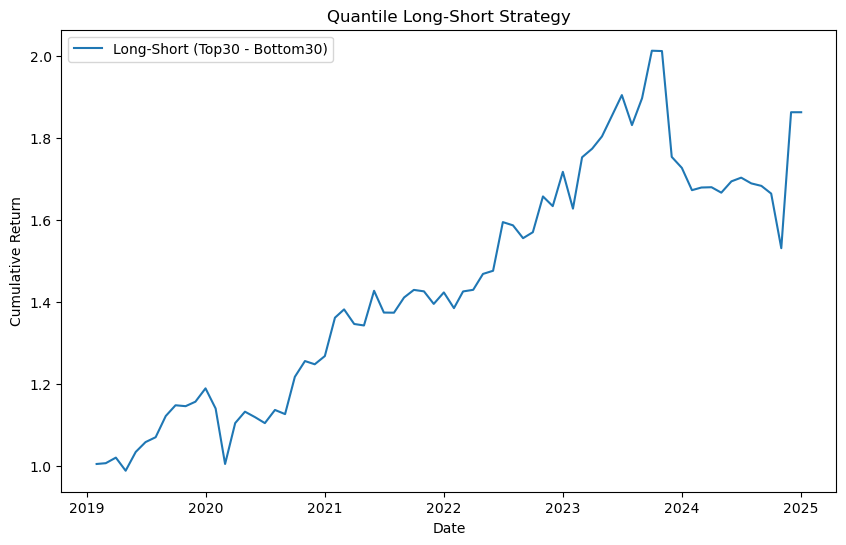

Final Long-Short Cumulative Return: 186.36%


In [127]:
df = strategy_df.copy()
df = df.sort_values(['filing_date'])

def assign_decile(group):
    group['decile'] = pd.qcut(
        group['predicted_return'],
        q=10,                   # 10 deciles
        labels=False,           # bins become 0..9
        duplicates='drop'       # drop any duplicate edges if not enough unique values
    ) + 1                       # shift to 1..10
    return group

df = df.groupby('filing_date', group_keys=False).apply(assign_decile)

df['group'] = np.where(
    df['decile'] >= 8, 'top',
    np.where(df['decile'] <= 3, 'bottom', 'middle')
)

grouped = (
    df.groupby(['filing_date', 'group'])['actual_return']
      .mean()
      .unstack('group')
      .rename_axis(columns=None)   # optional, just for cleanliness
      .fillna(0)                   # if a date had no tickers in top or bottom
)

grouped['ls_return'] = grouped['top'] - grouped['bottom']

grouped['ls_cumret'] = (1 + grouped['ls_return']).cumprod()

grouped['top_cumret'] = (1 + grouped['top']).cumprod()

grouped['short_cumret'] = (1 + -grouped['bottom']).cumprod()  # short side alone

plt.figure(figsize=(10,6))
plt.plot(grouped.index, grouped['ls_cumret'], label='Long-Short (Top30 - Bottom30)')
plt.title("Quantile Long-Short Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

final_ls_return = grouped['ls_cumret'].iloc[-1]
print(f"Final Long-Short Cumulative Return: {final_ls_return:.2%}")


In [128]:
def compute_performance_metrics(returns_series, freq=12):
    """
    Given a pd.Series of periodic returns (e.g. monthly),
    compute annualized return, annualized volatility, and Sharpe ratio.
    freq=12 for monthly data (12 months/yr),
         =252 for daily data, etc.
    Returns a dict with keys: 'annual_return', 'annual_volatility', 'sharpe_ratio'
    """
    mean_ret = returns_series.mean()     # average period return
    std_ret  = returns_series.std()      # std dev of period returns
    
    # Annualized return (geometric)
    annual_return = (1 + mean_ret)**freq - 1
    
    # Annualized volatility
    annual_vol = std_ret * np.sqrt(freq)
    
    # Sharpe ratio (no risk-free rate subtracted here)
    # be sure std_ret != 0
    if std_ret != 0:
        sharpe = (mean_ret / std_ret) * np.sqrt(freq)
    else:
        sharpe = np.nan
    
    return {
        'annual_return': annual_return,
        'annual_volatility': annual_vol,
        'sharpe_ratio': sharpe
    }

top_metrics = compute_performance_metrics(grouped['top'], freq=12)
bottom_metrics = compute_performance_metrics(grouped['bottom'], freq=12)
ls_metrics = compute_performance_metrics(grouped['ls_return'], freq=12)

print("Top Portfolio (Deciles 8-10)")
print(f"Annual Return:     {top_metrics['annual_return']:.2%}")
print(f"Annual Volatility: {top_metrics['annual_volatility']:.2%}")
print(f"Sharpe Ratio:      {top_metrics['sharpe_ratio']:.3f}")

print("Bottom Portfolio (Deciles 1-3)")
print(f"Annual Return:     {bottom_metrics['annual_return']:.2%}")
print(f"Annual Volatility: {bottom_metrics['annual_volatility']:.2%}")
print(f"Sharpe Ratio:      {bottom_metrics['sharpe_ratio']:.3f}")

print("Long-Short (Top - Bottom)")
print(f"Annual Return:     {ls_metrics['annual_return']:.2%}")
print(f"Annual Volatility: {ls_metrics['annual_volatility']:.2%}")
print(f"Sharpe Ratio:      {ls_metrics['sharpe_ratio']:.3f}")

Top Portfolio (Deciles 8-10)
Annual Return:     25.48%
Annual Volatility: 23.88%
Sharpe Ratio:      0.960
Bottom Portfolio (Deciles 1-3)
Annual Return:     11.84%
Annual Volatility: 21.37%
Sharpe Ratio:      0.526
Long-Short (Top - Bottom)
Annual Return:     12.32%
Annual Volatility: 16.12%
Sharpe Ratio:      0.724
